# Democratising parliamentary data 

In [16]:
# Importing modules
import io
import requests
import pandas as pd
import csv
import mnis
import time
import datetime
from datetime import timedelta

# Importing created .py files
import getmps as gmp
import getvotes as gv
import groupdata as gd
import mongodatabase as md
import createpartyscores as cps
import creatempscores as cmps
import kmeans as km

## Part 1: Get MPs

The first part of the project uses the 'get_mps' module to create a dataframe of MPs between the start and end dates selected. This dataframe contains key information for analysis including the mps party, whether they are male or female and the number of days they have served as an MP. This module utilises a module I called 'mnis' which has easy to use functions to query the MP data held on the 'Members Names Information Service.'

In the code blocks below, I have collected MPs for the dates ranging 2001-2005, however I have also collected data for MPs between 2005-2007. This is saved in the 'DATA' folder and is used later in the program for analysis.

In [17]:
# Setting start and end dates to collect MP identification info. 
start_date = datetime.date(2001, 7, 1)
end_date = datetime.date(2005, 4, 1)

In [18]:
# Calling the 'MakeMpDf' class from the 'getmps' module.
make_mp_df = gmp.MakeMpDf(start_date, end_date)

In [19]:
# Calling the 'create_df' function, creating a dataframe of mps serving during the dates above.
mp_df = make_mp_df.create_df()

In [20]:
# Saving the dataframe to a csv file.
mp_df.to_csv('DATA/MPS-ID-2001-5.csv', sep=',', encoding='utf-8')

# Reseting the index.
mp_df = mp_df.reset_index()

# Outputting the first line of the dataframe.
mp_df.head(1)

,member_id,constituency,date_of_birth,days_service,first_start_date,gender,list_name,party
0,172,Hackney North and Stoke Newington,1953-09-27,6433,1987-06-11,F,"Abbott, Ms Diane",Labour


## Part 2: Get votes

In part two, I call the 'get_votes' module. I created this module to query the data.parliament API platform to collect all the votes for the MPs using the dates assigned above. The module uses multiprocessing to speed up this process, breaking the list of MPs into groups of arrays for each process to manage. As mentioned above this process can be quite slow and pulling in all the data for the MPs took over 7 hours. Thats why I have created a segment of the list of MPs (9) to illustrate the process in a reduced ammount of time. The full data is stored in a different folder as it is used later.

As with the MP dataframe, I have run this program twice, the second time to gather the voting data for 2005-2007. This data is also stored in the 'DATA' folder and is used later on in the program.

In [21]:
# Creating a new variable to hold the 'member_id' fields as a list.
mps_ids = mp_df['member_id'].tolist()
# Setting the number variable to use in the next module.
number = 9

In [22]:
# Calling the 'MakeVoteFiles' class from the 'getvotes' module.
make_vote_files = gv.MakeVoteFiles(mps_ids, number)

In [12]:
# Calling the 'make_vote_files' function, collecting a segment of MPs votes. This can take about 5-10 minutes.
collect_all_votes = make_vote_files.build_vote_files()

Multiprocessing finished. Votes from 9 mps collected. Check folder DATA/votes-segment for results.


## Part 3: Group data

In this part, I use the 'groupdata' module to merge and reformat the vote files collected in part 2. This part also uses multiprocessing, this time using 8 processes to speed up the program. Using this technique allows me to read all csv files to a list of dataframes and simultaniously combine them to one dataframe. This is a vast improvement of my original, more manual set of functions which took over half an hour to processes.

In [71]:
# Calling the 'CreateVoteDf' from the 'groupdata' module.
create_vote_df = gd.CreateVoteDf(start_date, end_date)

In [72]:
# Calling the 'build_vote_df' function, this should take about 5 minutes. 
votes_df = create_vote_df.build_vote_df(start_date, end_date)

Multiprocessing finished. Now adjusting dataframe...
Completed. All files now read in and combined in one dataframe.


In [73]:
mp_df = pd.read_csv('DATA/MPS-ID-2001-5.csv', sep=',',error_bad_lines=False)

In [74]:
# Resetting the index
votes_df = votes_df.reset_index()

# Saving file to csv.
votes_df.to_csv('DATA/VOTING-2001-5.csv', sep=',', encoding='utf-8')

# Outputting the first line of the dataframe.
votes_df.head(1)

,uin,date,title,67,122,83,599,130,366,583,...,80,1454,321,1455,518,381,37,209,58,171
0,CD:2005-03-10:131,2005-03-10,Prevention of Terrorism Bill,no,aye,did not vote,aye,aye,no,aye,...,aye,no,aye,aye,aye,aye,aye,did not vote,did not vote,aye


In [75]:
# Calling the 'TransformVoteDf' from the 'groupdata' module.
transform_vote_df = gd.TransformVoteDf(mp_df)

In [76]:
# Calling the 'pivot_df' function using the votes_df dataframe and outputting the first line.
pivot_df = transform_vote_df.pivot_df(votes_df)
pivot_df.head(1)

index,member_id,CD:2005-03-10:131,CD:2005-03-10:132,CD:2005-03-10:133,CD:2005-03-10:134,CD:2005-03-10:135,CD:2005-03-10:136,CD:2005-03-10:137,CD:2005-03-10:138,CD:2005-03-10:139,...,CD:2005-02-25:97,CD:2005-02-25:98,CD:2005-02-25:99,CD:2002-07-09:300,CD:2005-02-25:96,CD:2005-03-18:147,CD:2005-03-18:148,CD:2004-04-23:141,CD:2003-03-14:114,CD:2004-05-21:182
0,67,no,no,no,no,no,no,no,no,no,...,did not vote,did not vote,did not vote,did not vote,did not vote,did not vote,did not vote,did not vote,did not vote,did not vote


In [77]:
# Calling the 'votes to int' function, saving the results to csv and outputting the first line.
df_int = transform_vote_df.votes_to_int(pivot_df)
df_int.to_csv('DATA/VOTES-INT.csv', sep=',', encoding='utf-8')
df_int.head(1)

index,member_id,CD:2005-03-10:131,CD:2005-03-10:132,CD:2005-03-10:133,CD:2005-03-10:134,CD:2005-03-10:135,CD:2005-03-10:136,CD:2005-03-10:137,CD:2005-03-10:138,CD:2005-03-10:139,...,CD:2005-02-25:97,CD:2005-02-25:98,CD:2005-02-25:99,CD:2002-07-09:300,CD:2005-02-25:96,CD:2005-03-18:147,CD:2005-03-18:148,CD:2004-04-23:141,CD:2003-03-14:114,CD:2004-05-21:182
0,67,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,0,0,0,0,0,0,0,0,0,0


In [78]:
# Calling the 'merge_mp_id' function to merge the MPs votes with their identification fields.
df_int_id = transform_vote_df.merge_mp_id(df_int)
# Saving the result to csv and outputting the first line.
df_int_id.to_csv('DATA/VOTES-INT-ID.csv', sep=',', encoding='utf-8')
df_int_id.head(1)

,member_id,CD:2005-03-10:131,CD:2005-03-10:132,CD:2005-03-10:133,CD:2005-03-10:134,CD:2005-03-10:135,CD:2005-03-10:136,CD:2005-03-10:137,CD:2005-03-10:138,CD:2005-03-10:139,...,CD:2004-04-23:141,CD:2003-03-14:114,CD:2004-05-21:182,constituency,date_of_birth,days_service,first_start_date,gender,list_name,party
0,67,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,0,0,0,Hertsmere,1956-09-14,4693,1992-04-09,M,"Clappison, Mr James",Conservative


## Part 4: Make MongoDB databse

In part 4 I create a database with a series of collections using MongoDB. I found this method highly useful for my data, allowing me to create new collections from calculations and aggregations of existing collections. As my intentions are for quick analysis rather than long term data collection, I found MongoDB to work better than using a relational database system. 

In [79]:
# Calling the 'CreateCollections' class from the 'mongodatabase' module.
create_collections = md.CreateCollections("VOTES_IN_PARLIAMENT")

In [80]:
# Calling the 'connect_mongo' function starting a connection with mongodb and creating a new database.
db = create_collections.connect_mongo()

In [81]:
# Calling the 'insert_all_data' funtion to insert all csv data into new mongodb collections.
create_collections.insert_all_data(db)

# Viewing the newly created collections.
cols = db.collection_names()
for c in cols:
    print(c)

votes
votes_int
votes_id
mps


In [82]:
# Calling the 'PerformAggregations' class from the 'mongodatabase' module.
perform_aggregations = md.PerformAggregations()

In [83]:
# Calling the 'embed_votes' function, embedding the MPs votes inside an array in a document with their id fields. 
perform_aggregations.embed_votes(db)

In [84]:
# Calling the 'clean_array' function, unwinding the embedded arrays and removing un-needed fields.
perform_aggregations.clean_array(db)

In [85]:
# Outputting the keys from the 'mps_votes' collection. The votes key will contain the embedded array with their votes.
mps_votes = db.mps_votes
doc = mps_votes.find_one()

for key_names in doc:
    print(key_names)   

_id
member_id
constituency
date_of_birth
days_service
first_start_date
gender
list_name
party
votes


In [86]:
# Calling the 'party_votes_sort' function to sort the 'mps_votes' collection into new collections grouped by party.
perform_aggregations.party_votes_sort(db)

In [87]:
# Outputting the results of an MP document in the labour mp collection.
lab = db.mp_lab
labour_mp = lab.find( { "list_name": "Abbott, Ms Diane" } )

for mp in labour_mp:
    print(mp)

{'_id': ObjectId('5abe0b5bcb378e02276d1d4a'), 'member_id': 172, 'constituency': 'Hackney North and Stoke Newington', 'date_of_birth': '1953-09-27', 'days_service': 6433, 'first_start_date': '1987-06-11', 'gender': 'F', 'list_name': 'Abbott, Ms Diane', 'party': 'Labour', 'votes': {'CD:2005-03-10:131': -1, 'CD:2005-03-10:132': -1, 'CD:2005-03-10:133': -1, 'CD:2005-03-10:134': -1, 'CD:2005-03-10:135': -1, 'CD:2005-03-10:136': -1, 'CD:2005-03-10:137': 0, 'CD:2005-03-10:138': -1, 'CD:2005-03-10:139': -1, 'CD:2005-03-10:140': -1, 'CD:2005-03-10:141': -1, 'CD:2005-03-10:142': 0, 'CD:2005-03-09:121': 0, 'CD:2005-03-09:122': -1, 'CD:2005-03-09:123': -1, 'CD:2005-03-09:124': -1, 'CD:2005-03-09:125': -1, 'CD:2005-03-09:126': -1, 'CD:2005-03-09:127': -1, 'CD:2005-03-09:128': -1, 'CD:2005-03-08:118': -1, 'CD:2005-03-08:120': 0, 'CD:2005-03-07:114': 0, 'CD:2005-03-02:112': 0, 'CD:2005-03-01:105': 0, 'CD:2005-03-01:108': 0, 'CD:2005-03-01:109': 0, 'CD:2005-02-28:100': -1, 'CD:2005-02-28:103': -1, 'CD

## Part 5: Run javascript map-reduce-count

For the next part of the program, you will need to run a javascript script file in the command line using the prefix 'mongo.' This file uses map-reduce to count all 'yes' (1), 'no' (-1) and 'did-not-vote' (0) cases for each party for each vote. I looked into using pymongo's capabilities for map-reduce, but found the code a bit limiting and the online resources available sparse. Using a js script, also allowed me to better learn mongodb code via the command line, which was useful. See below for the intructions on how to run the code.

In command line:
1. Change to program folder
2. Run >> mongo map-reduce-count.js (this should take about 30 seconds)
3. Check the output collections in the cell below 

In [39]:
# Testing the results from the map-reduce count. 
lab_vote_results = db.lab_vote_results
# Looking for the results of a specific vote by searching it's 'uin' code.
lab_vote = lab_vote_results.find( { "_id": "CD:2001-07-11:21" } )

# Outputting the results of the search. As there where no 'no' votes, the '-1' key does not appear.
for outcome in lab_vote:
    print(outcome) 

{'_id': 'CD:2001-07-11:21', 'value': {'0': 113.0, '1': 300.0}}


## Part 6: Create party scores

After successfully running the map-reduce file in command line, part 6 uses additional mongodb aggregations to develop the vote score collections.

In [40]:
# Calling the 'GetPartyScores' class from the 'createpartyscores module.
get_party_scores = cps.GetPartyScores()

In [41]:
# Calling the 'replace_empty_votes' function and testing the results below.
get_party_scores.replace_empty_votes(db)

# Using the same vote id as above, the '-1' field is not showing with '0' votes.
lab_vote_results = db.lab_vote_results
lab_vote = lab_vote_results.find( { "_id": "CD:2001-07-11:21" } )

for outcome in lab_vote:
    print(outcome) 

{'_id': 'CD:2001-07-11:21', 'value': {'0': 113.0, '1': 300.0, '-1': 0}}


In [42]:
# Calling the 'create_party_scores' function to create a score for each vote by each of the main parties.
get_party_scores.create_party_scores(db)

# Testing the 'lab_score' collection. The output shows the labour score for the same vote used above.
lab_score = db.lab_score
# The score relates to the number of yes, no and 'not voting' results for each mp in that party.
lab_vote_score = lab_score.find( { "_id": "CD:2001-07-11:21" } )

# The result below shows a high percentage of 'yes' vote to the vote id below.
for score in lab_vote_score:
    print(score)    

{'_id': 'CD:2001-07-11:21', 'score': 0.7263922518159807}


In [43]:
# Calling the 'create_majority_socres' function, this gives each vote either 1,-1 or 0 depending on the vote majority.
get_party_scores.create_majority_scores(db)

In [44]:
# Testing the 'lab_vote_maj_score' collection.
lab_maj_score = db.lab_maj_score
majority_scores = lab_maj_score.find( { "_id": "CD:2001-07-11:21" } )

# The result shows a majority score of 1 (yes) to the vote id below.
for score in majority_scores:
    print(score)  

{'_id': 'CD:2001-07-11:21', 'score': 1}


## Part 7: Run javascript map-reduce-pivot

In Part 7 I have built another map-reduce script to be run in the command line. This script uses the 'vote score' collections created above, pivoting the data so the vote ids become keys. This is needed for analysis further on in the program. See below for the intructions on how to run the code.

In command line:

Change to program folder
1. Run >> mongo map-reduce-pivot.js (this should take just a couple of seconds)
2. Check the output collections in the cell below
3. Some more text explaining what this does....

In [45]:
# Testing the results of the 'map-reduce-pivot.' 
lab_score = db.lab_score
doc = lab_vote_results.find_one()

lab_score = db.lab_score
lab_vote_score = lab_score.find( { "_id": "CD:2001-07-11:21" } )

for score in lab_vote_score:
    print(score)    

{'_id': 'CD:2001-07-11:21', 'value': {'CD:2001-07-11:21': 0.7263922518159807}}


### Export collections as JSON files

Now all the needed aggregations and calcultions have been performed in MongoDB, I then export my data as JSON format for further analysis in python. The code below allows you to do this, however the data has already been collected and is stored in the correct folder so, if needed, you can skip this step.

In command line execute:
1. mongoexport --db VOTES_IN_PARLIAMENT --collection con_maj_score --out DATA/mongo-db/con_maj_score.json
2. mongoexport --db VOTES_IN_PARLIAMENT --collection con_score --out DATA/mongo-db/con_score.json
3. mongoexport --db VOTES_IN_PARLIAMENT --collection con_votes_int --out DATA/mongo-db/con_votes_int.json
4. mongoexport --db VOTES_IN_PARLIAMENT --collection lab_maj_score --out DATA/mongo-db/lab_maj_score.json
5. mongoexport --db VOTES_IN_PARLIAMENT --collection lab_score --out DATA/mongo-db/lab_score.json
6. mongoexport --db VOTES_IN_PARLIAMENT --collection lab_votes_int --out DATA/mongo-db/lab_votes_int.json
7. mongoexport --db VOTES_IN_PARLIAMENT --collection ld_maj_score --out DATA/mongo-db/ld_maj_score.json
8. mongoexport --db VOTES_IN_PARLIAMENT --collection ld_score --out DATA/mongo-db/ld_score.json
9. mongoexport --db VOTES_IN_PARLIAMENT --collection ld_votes_int --out DATA/mongo-db/ld_votes_int.json

## Part 8: Count mp scores

This part uses the 'countmpsscores' module, creating loyalty scores for analysis.

In [88]:
# Calling the 'AnalyseVoteLoyalty' class in the 'countmpsscores' module.
analyse_vote_loyalty = cmps.AnalyseVoteLoyalty()

In [89]:
# Calling the 'get_vote_party_loyalty' function and assigning it to 'vote_party_loyalty'
vote_party_loyalty = analyse_vote_loyalty.get_vote_party_loyalty(votes_df)

In [90]:
# Looking at the first ten results from the 'vote_party_loyalty' dataframe and saving the results to csv.
vote_party_loyalty.to_csv('DATA/VOTES-PARTY-LOYALTY.csv', sep=',', encoding='utf-8')
vote_party_loyalty.tail(10)

,uin,lab_score,con_score,ld_score,total,date,title
1223,CD:2005-03-10:140,0.882353,1.000000,1.000000,0.960784,2005-03-10,Prevention of Terrorism Bill
1224,CD:2005-03-10:141,0.909366,1.000000,1.000000,0.969789,2005-03-10,Prevention of Terrorism Bill
1225,CD:2005-03-10:142,1.000000,1.000000,1.000000,1.000000,2005-03-10,Prevention of Terrorism Bill
1226,CD:2005-03-15:143,1.000000,1.000000,1.000000,1.000000,2005-03-15,Inquiries Bill [Lords]
1227,CD:2005-03-15:144,1.000000,1.000000,0.928571,0.976190,2005-03-15,Inquiries Bill [Lords]
1228,CD:2005-03-16:145,1.000000,0.981308,1.000000,0.993769,2005-03-16,Budget Resolutions
1229,CD:2005-03-16:146,1.000000,1.000000,1.000000,1.000000,2005-03-16,Constitutional Reform Bill [Lords]
1230,CD:2005-03-18:147,1.000000,1.000000,1.000000,1.000000,2005-03-18,Motions to sit in private
1231,CD:2005-03-18:148,1.000000,0.750000,1.000000,0.916667,2005-03-18,Smoking in Public Places (Wales) Bill
1232,CD:2005-03-22:149,1.000000,1.000000,1.000000,1.000000,2005-03-22,Budget Resolutions and Economic Situation


In [91]:
# Calling the 'get_mp_party_loyalty' assigning to 'mp_party_loyalty' and viewing the first line of the dataframe.
mp_party_loyalty = analyse_vote_loyalty.get_mp_party_loyalty(mp_df)
mp_party_loyalty.head(1)

,member_id,score,constituency,date_of_birth,days_service,first_start_date,gender,list_name,party,maj_score
0,67,0.97842,Hertsmere,1956-09-14,4693,1992-04-09,M,"Clappison, Mr James",Conservative,0.990099


### MP loyalty

The cell below depicts the five lowest scoring MPs based on party loyalty. It is interesting to see that 3 out of 5 of these MPs are from the ruling party, labour.

In [92]:
# Calling the 'smallest_mp_value' function to showest the 5 MPs with the lowest loyalty score.
low_mp_scores = analyse_vote_loyalty.smallest_mp_value(mp_party_loyalty, 5)
low_mp_scores

,member_id,score,constituency,date_of_birth,days_service,first_start_date,gender,list_name,party,maj_score
30,474,0.355615,Ribble Valley,1957-11-10,4693,1992-04-09,M,"Evans, Mr Nigel",Conservative,0.371277
316,260,0.355615,North Swindon,1952-05-20,2868,1997-05-01,M,"Wills, L.",Labour,0.371277
344,467,0.355615,Chorley,1957-06-10,2868,1997-05-01,M,"Hoyle, Sir Lindsay",Labour,0.371277
564,217,0.355615,Bristol South,1954-05-02,6433,1987-06-11,F,"Primarolo, B.",Labour,0.371277
575,397,0.355615,"Sheffield, Hallam",1966-02-11,2868,1997-05-01,M,"Allan of Hallam, L.",Liberal Democrat,0.371277


### Party loyalty

In the below cell you can see the commons division bills with the 5 lowest scoring loyalty from all the parties combined. This gives you an indication of what votes are most divisive across all parties, causing the largest number of MPs to sway from the party majority. Looking at the results below I can infer that the modernisation of the house of commons and the house of lords reform are most divisive. It is interesting to note that these bills mainly effect the people that are voting on it.

In [93]:
# Calling the 'smallest_party_value_total' function to get the five votes with the overall lowest loyalty score.
low_party_scores = analyse_vote_loyalty.smallest_party_value_total(vote_party_loyalty, 5)
low_party_scores

,uin,lab_score,con_score,ld_score,total,date,title
1130,CD:2005-01-26:47,0.006211,0.348837,0.100000,0.151683,2005-01-26,Modernisation of the House of Commons
230,CD:2002-05-14:238,0.121076,0.533981,0.285714,0.313590,2002-05-14,Modernisation of the House of Commons [Relevan...
430,CD:2003-02-04:77,0.112392,0.134328,0.702128,0.316283,2003-02-04,House of Lords Reform
431,CD:2003-02-04:78,0.127907,0.013889,0.877551,0.339782,2003-02-04,House of Lords Reform
231,CD:2002-05-14:239,0.004608,0.571429,0.466667,0.347568,2002-05-14,Modernisation of the House of Commons [Relevan...


### Liberal Democrat party loyalty

The table below depicts the five lowest scoring votes based on the Liberal Democrats party loyalty. Of note is the divisiveness of the two hunting bills, this highlights an area of contention within the liberal democrat party.

In [94]:
# Calling the 'smallest_ld_value' function to get the five votes with the lowest Liberal Democrat loyalty score.
low_ld_scores = analyse_vote_loyalty.smallest_ld_value(vote_party_loyalty, 5)
low_ld_scores

,uin,lab_score,con_score,ld_score,total,date,title
381,CD:2002-12-16:28,0.993464,1.000000,0.022222,0.671895,2002-12-16,Hunting Bill
1072,CD:2004-11-16:329,0.849057,0.958042,0.023256,0.610118,2004-11-16,Hunting Bill
29,CD:2001-07-19:37,0.824427,0.511111,0.034483,0.456674,2001-07-19,Select Committees
1049,CD:2004-11-02:306,0.708609,1.000000,0.045455,0.584688,2004-11-02,Children Bill [Lords]
113,CD:2001-12-18:121,0.928105,1.000000,0.090909,0.673005,2001-12-18,Facilities of the House


### Conservative party loyalty

The chart below depicts the lowest loyalty scores for the conservative party. Again you can see the occurance of the House of Lords reform and Modernisation of the House of Commons. It is also interesting to note the Civil Partnership bill as another divisive vote.

In [95]:
# Calling the 'smallest_con_value' function to get the five votes with the lowest Conservative loyalty score.
low_con_scores = analyse_vote_loyalty.smallest_con_value(vote_party_loyalty, 5)
low_con_scores

,uin,lab_score,con_score,ld_score,total,date,title
431,CD:2003-02-04:78,0.127907,0.013889,0.877551,0.339782,2003-02-04,House of Lords Reform
1157,CD:2005-02-07:74,0.846690,0.019608,1.000000,0.622099,2005-02-07,Serious Organised Crime and Police Bill
1058,CD:2004-11-09:315,0.986532,0.063291,1.000000,0.683274,2004-11-09,Civil Partnerships Bill [Lords]
583,CD:2003-06-13:230,1.000000,0.076923,1.000000,0.692308,2003-06-13,Fireworks Bill
326,CD:2002-10-29:334,0.936306,0.090909,1.000000,0.675738,2002-10-29,Modernisation of the House of Commons


### Labour party loyalty

Finally, the table below looks at the 5 lowest scoring labour votes, based on loyalty. It is interesting to note, that unlike the other two parties, all 5 of the votes are concerned with internal parliamentary matters.

In [96]:
# Calling the 'smallest_lab_value' function to get the five votes with the lowest Labour loyalty score.
low_lab_scores = analyse_vote_loyalty.smallest_lab_value(vote_party_loyalty, 5)
low_lab_scores

,uin,lab_score,con_score,ld_score,total,date,title
231,CD:2002-05-14:239,0.004608,0.571429,0.466667,0.347568,2002-05-14,Modernisation of the House of Commons [Relevan...
1130,CD:2005-01-26:47,0.006211,0.348837,0.100000,0.151683,2005-01-26,Modernisation of the House of Commons
429,CD:2003-02-04:76,0.014327,0.197183,0.877551,0.363020,2003-02-04,House of Lords Reform
229,CD:2002-05-14:237,0.043137,0.576923,1.000000,0.540020,2002-05-14,Modernisation of the House of Commons [Relevan...
1050,CD:2004-11-03:307,0.060773,0.944954,0.609756,0.538495,2004-11-03,Members Allowances


## Part 9: PCA analysis with clustering

Finally, in Part 9 the 'kmeans' module is used to perform cluster analysis of the MPs voting records using principle component analysis.

In [97]:
# Reading in the MP and vote data collected from 2005-2007 to compare results.
mp_df_05_07 = pd.read_csv('DATA/MPS-ID-2005-7.csv', sep=',',error_bad_lines=False)
df_int_05_07 = pd.read_csv('data/VOTES-INT-5-7.csv', sep=',', index_col=0, error_bad_lines=False)

mp_df_05_07.head(1)

,member_id,constituency,date_of_birth,days_service,first_start_date,gender,list_name,party
0,172,Hackney North and Stoke Newington,1953-09-27,7139,1987-06-11,F,"Abbott, Ms Diane",Labour


In [98]:
# Calling the PlotPCA + PlotPCA_05_07 classes from the kmeans module.
plot_pca = km.PlotPCA()
plot_pca_05_07 = km.PlotPCA_05_07()

In [99]:
# Calling the 'votes_to_pca' functions, collecting PCA results for the 2001-5 and 2005-7 data. 
mps_pca = plot_pca.votes_to_pca(df_int, mp_df)
mps_pca_05 = plot_pca_05_07.votes_to_pca(df_int_05_07, mp_df_05_07)

In [100]:
# Outputting the first line of the 'mps_pca' dataframe. 
mps_pca.head(3)

,member_id,PC1,PC2,constituency,date_of_birth,days_service,first_start_date,gender,list_name,party
0,67,29.743268,-4.889614,Hertsmere,1956-09-14,4693,1992-04-09,M,"Clappison, Mr James",Conservative
1,122,-17.654888,0.157215,Peterborough,1954-12-23,2868,1997-05-01,F,"Clark, Mrs Helen",Labour
2,83,-17.668637,-2.110270,Gillingham,1957-04-29,2868,1997-05-01,M,"Clark, Paul",Labour


### Clustering votes by party 2001-2005

In the plot below you can see the results from the PCA performed on the voting records of the MPs in parliament between 2001-2005. As you can see, party divisions are clearly defined. 


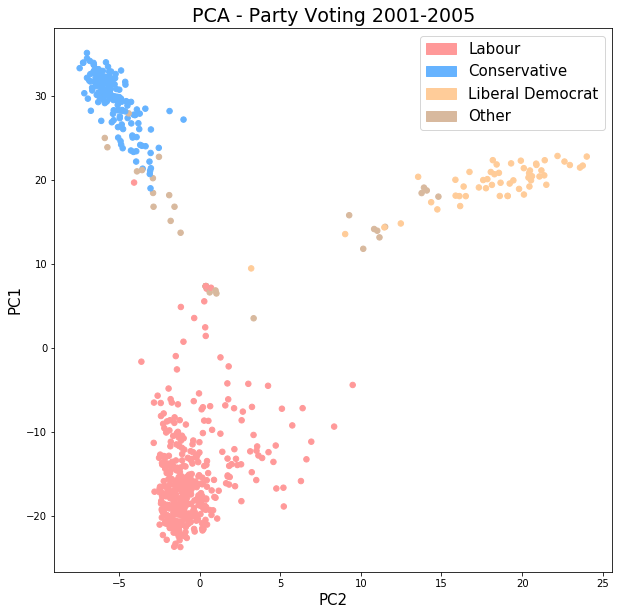

In [101]:
# Calling the 'cluster_parties' function to plot the PCA voting results for the 2001-2005 parties. 
plot_pca.cluster_parties(mps_pca)

### Clustering votes by party 2005-2007

In this second plot, as the government is now ruled by an unelected leader Gordon Brown, there begins to be a slight dispursement in party loyalty, particularly within the labour party. The fact that the majority of the party remains unmoved shows the power of the three line whip.


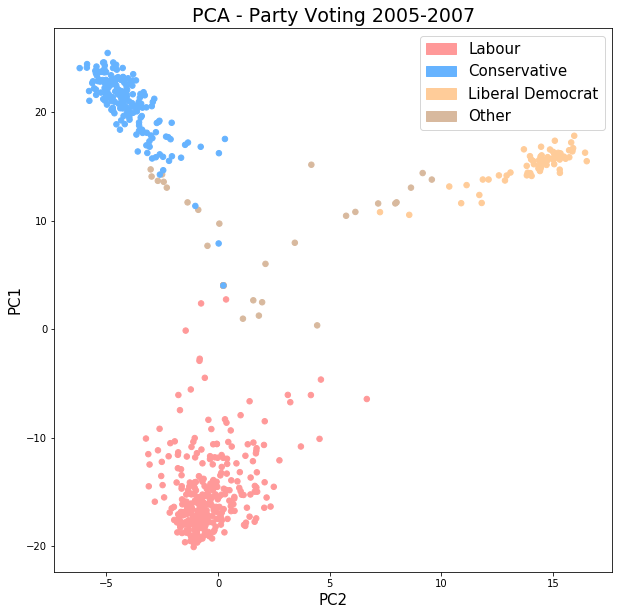

In [102]:
# Calling the 'cluster_parties' function to plot the PCA voting results for the 2005-2007 parties. 
plot_pca_05_07.cluster_parties(mps_pca_05)

### Clustering votes by Labour MPs 2001-2005

The next plot focuses on the Labour party distribution. When layering on the names of the MPs, it is here when the narratives behind the data begin to emerge. There are many interesting things to note here. Perhaps the most relevant at the moment is to see how Jeremy Corbyn, the current party leader was always a clear outlier from the party. Also you can see that the front bench at the time (eg Tony Blair, Gordon Brown, David Blunkett ect) are also group outside of the party. This is due to the analysis including not voting as a factor. This could indicate that front bench politicians are less frequent in their voting. One final thing of note, is the position of Mr Robert Jackson, a clear outlier from the party. This is likely becuase the MP defected from the Conservatives in 2005. It would appear that Mr Jacksons voting record is more inline with the Conservatives.

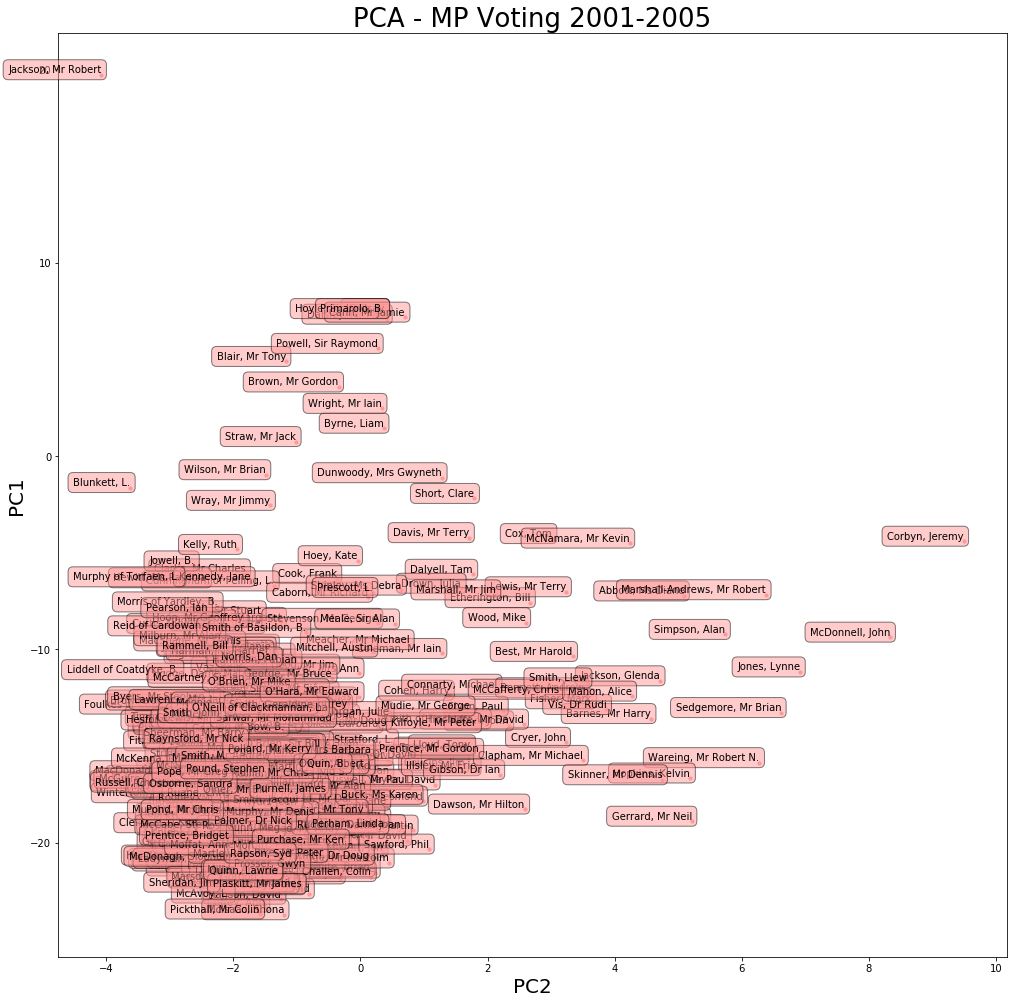

In [103]:
# Calling the 'cluster_mps' function to plot the PCA voting results for the 2001-2005 labour mps. 
plot_pca.cluster_mps(mps_pca)

### Clustering votes by Labour MPs 2005-2007

Finally, performing the same anaysis on the 2005-2007 data has allowed me to compare the party loyalty under the elected leader of Tony Blair against that of Gordon Brown who was unelected.

There is a wider distribution of MPs in this analysis, indicating decreased loyalty. Of particuar note, there is a widening gap between Tony Blair and the rest of the party. It is also of mention is the position of Robin Cook, who died in service in 2005 decreasing the amount of votes attended.

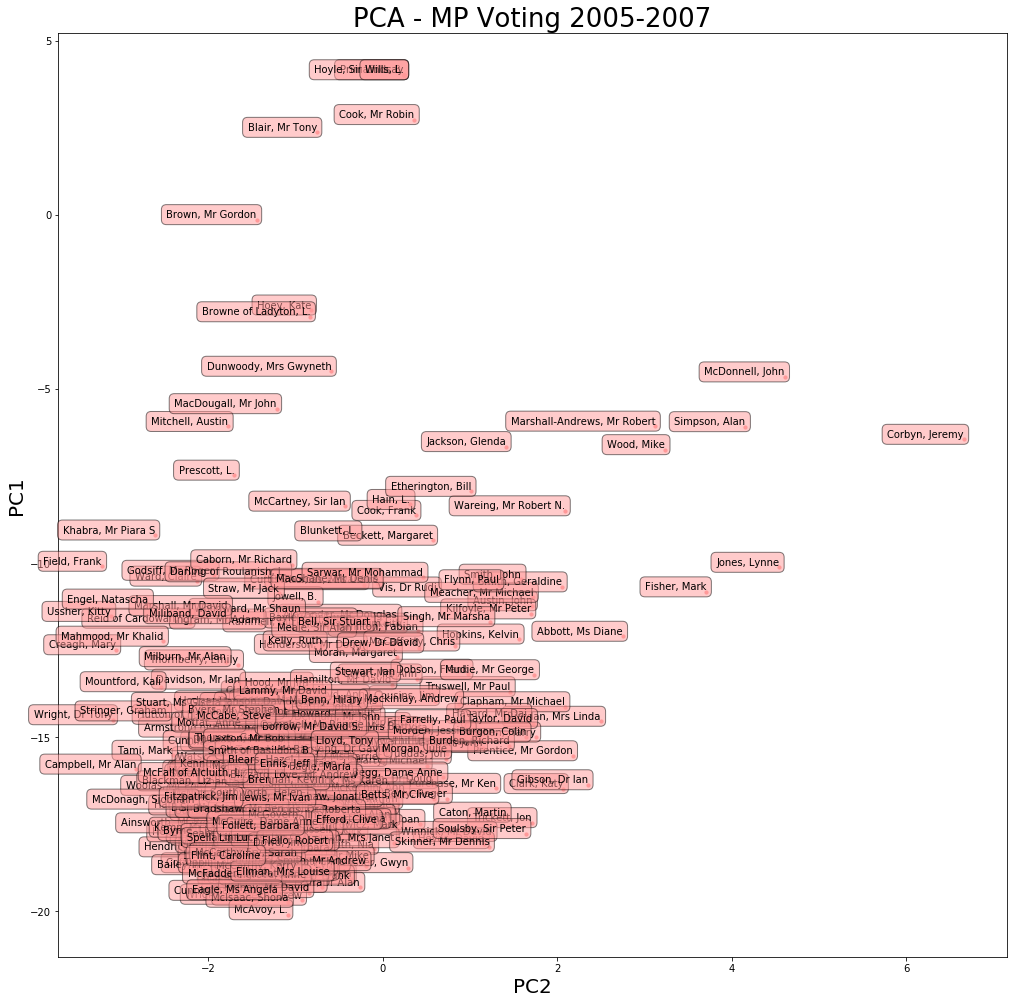

In [104]:
# Calling the 'cluster_mps' function to plot the PCA voting results for the 2005-2007 labour mps. 
plot_pca_05_07.cluster_mps(mps_pca_05)